# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications import VGG16
from keras_hist_graph import plot_history

from utils import load_images, plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [3]:
train_dir = 'dogs_224/train/'
validation_dir = 'dogs_224/validation/'
test_dir = 'dogs_224/test/'

STD_SIZE = (224, 224)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_2_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']

Loaded test images in test_features array: (51, 224, 224, 3)


print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

# Model

In [5]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_2_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 27,560,769
Trainable params: 27,560,769
Non-trainable params: 0
_________________________________________________________________


In [7]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 57s - loss: 0.2096 - acc: 0.8981 - val_loss: 0.1505 - val_acc: 0.9750

Epoch 00001: val_loss improved from inf to 0.15047, saving model to tl_fine_tuning_2_breeds
Epoch 2/1000
 - 22s - loss: 0.1903 - acc: 0.9167 - val_loss: 0.0713 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.15047 to 0.07135, saving model to tl_fine_tuning_2_breeds
Epoch 3/1000
 - 4s - loss: 0.1291 - acc: 0.9583 - val_loss: 0.0281 - val_acc: 0.9667

Epoch 00003: val_loss improved from 0.07135 to 0.02805, saving model to tl_fine_tuning_2_breeds
Epoch 4/1000
 - 4s - loss: 0.1106 - acc: 0.9676 - val_loss: 0.0820 - val_acc: 0.9750

Epoch 00004: val_loss did not improve from 0.02805
Epoch 5/1000
 - 7s - loss: 0.1434 - acc: 0.9537 - val_loss: 0.0841 - val_acc: 0.9667

Epoch 00005: val_loss did not improve from 0.02805
Epoch 6/1000
 - 4s - loss: 0.0894 - acc: 0.9722 - val_loss: 0.0187 - val_acc: 1.0000

Epoch 00006: val_loss improved from 0.02805 to 0.01871, saving model to tl_fine_tuning_2_breeds


## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 18s 346ms/step


[0.05120011977851391, 0.9607843160629272]

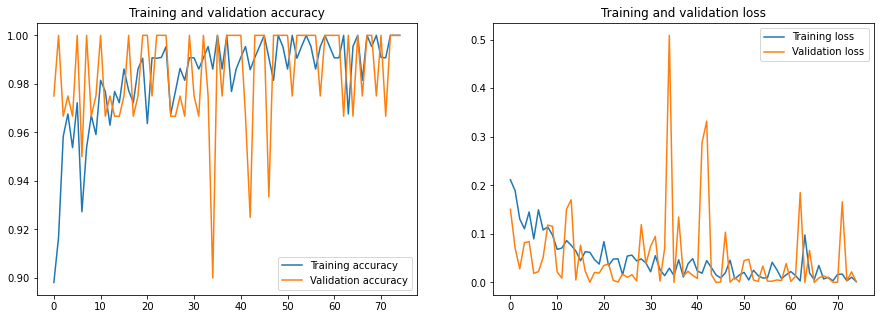

In [10]:
plot_accuracy_and_loss(history)

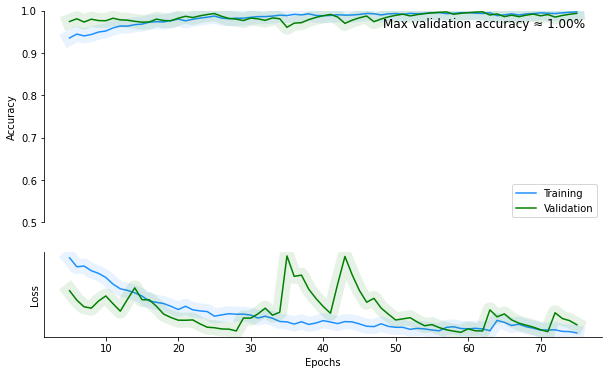

In [11]:
plot_history(history,xkcd=False)

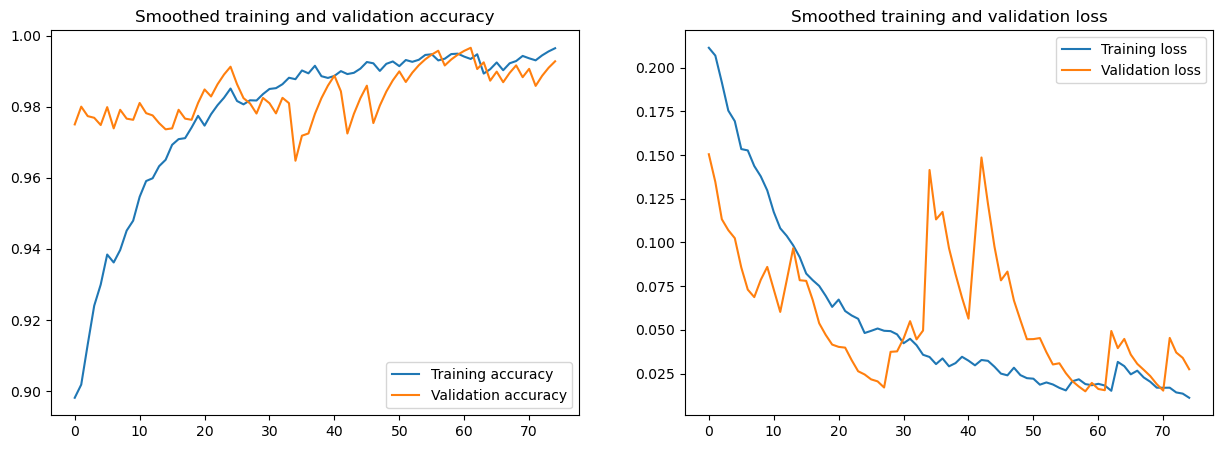

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_3_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

Loaded test images in test_features array: (89, 224, 224, 3)


## Model

In [14]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_3_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 27,561,795
Non-trainable params: 0
_________________________________________________________________


In [16]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 28s - loss: 2.4691 - acc: 0.5791 - val_loss: 0.8434 - val_acc: 0.7000

Epoch 00001: val_loss improved from inf to 0.84339, saving model to tl_fine_tuning_3_breeds
Epoch 2/1000
 - 22s - loss: 0.5561 - acc: 0.7781 - val_loss: 0.7900 - val_acc: 0.8088

Epoch 00002: val_loss improved from 0.84339 to 0.78999, saving model to tl_fine_tuning_3_breeds
Epoch 3/1000
 - 7s - loss: 0.3988 - acc: 0.8546 - val_loss: 0.0714 - val_acc: 0.9559

Epoch 00003: val_loss improved from 0.78999 to 0.07142, saving model to tl_fine_tuning_3_breeds
Epoch 4/1000
 - 7s - loss: 0.3813 - acc: 0.8648 - val_loss: 0.3347 - val_acc: 0.8088

Epoch 00004: val_loss did not improve from 0.07142
Epoch 5/1000
 - 7s - loss: 0.3482 - acc: 0.8980 - val_loss: 0.5377 - val_acc: 0.9118

Epoch 00005: val_loss did not improve from 0.07142
Epoch 6/1000
 - 8s - loss: 0.1884 - acc: 0.9325 - val_loss: 0.1377 - val_acc: 0.9500

Epoch 00006: val_loss did not improve from 0.07142
Epoch 7/1000
 - 8s - loss: 0.2761 - acc: 0.89

## Results

In [18]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 19s 214ms/step


[0.016894659927298775, 0.9887640476226807]

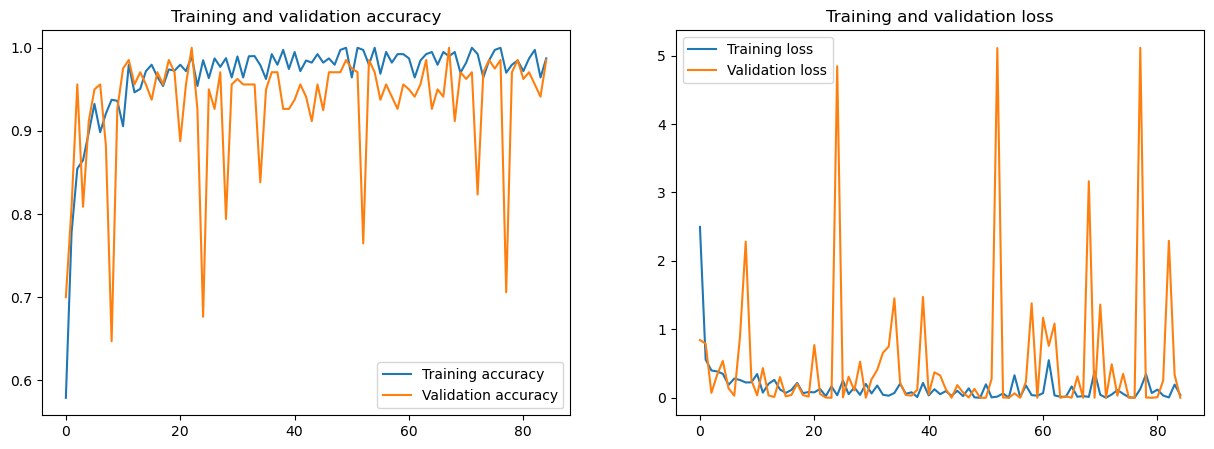

In [19]:
plot_accuracy_and_loss(history)

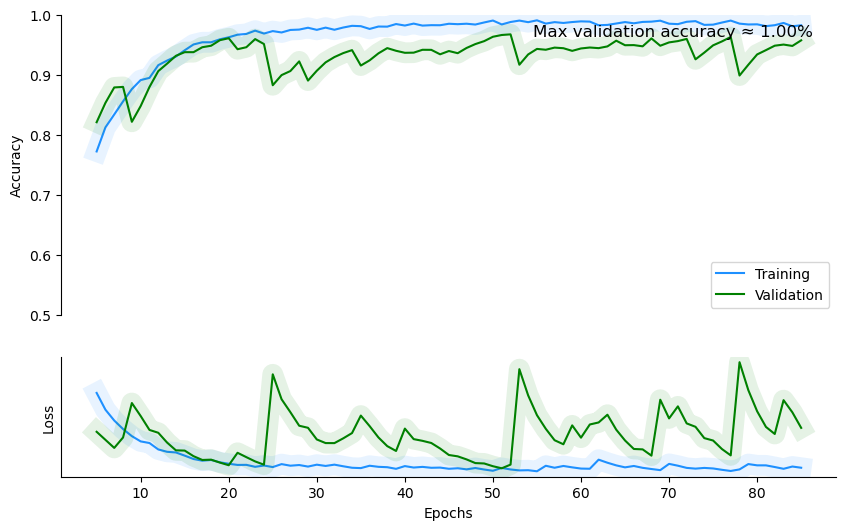

In [20]:
plot_history(history,xkcd=False)

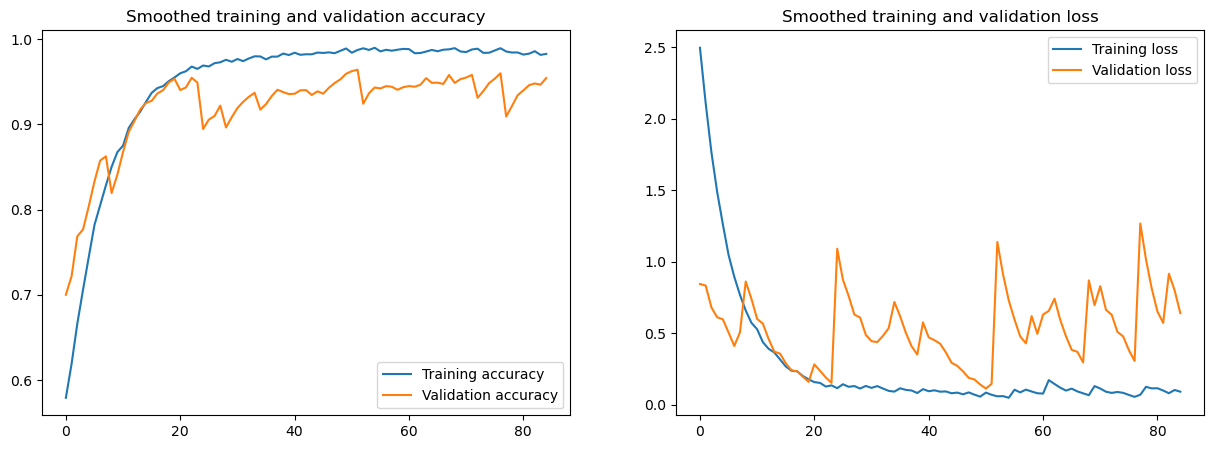

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

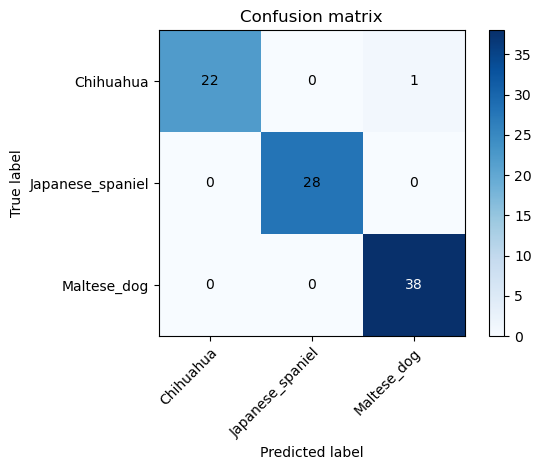

In [22]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [23]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_5_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

Loaded test images in test_features array: (143, 224, 224, 3)


In [24]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  666
Number of train classes:  5
Number of train samples per class: 133 

Number of validation samples:  143
Number of validation classes:  5
Number of validation samples per class: 29 

Number of test samples:  143
Number of test classes:  5
Number of test samples per class: 29 

Files for train subset for 5 classes 
 ['Chihuahua\\n02085620_10074.jpg', 'Chihuahua\\n02085620_10131.jpg', 'Chihuahua\\n02085620_10621.jpg', 'Chihuahua\\n02085620_1073.jpg', 'Chihuahua\\n02085620_10976.jpg', 'Chihuahua\\n02085620_11140.jpg', 'Chihuahua\\n02085620_11238.jpg', 'Chihuahua\\n02085620_11258.jpg', 'Chihuahua\\n02085620_11337.jpg', 'Chihuahua\\n02085620_11477.jpg', 'Chihuahua\\n02085620_1152.jpg', 'Chihuahua\\n02085620_11696.jpg', 'Chihuahua\\n02085620_11818.jpg', 'Chihuahua\\n02085620_11948.jpg', 'Chihuahua\\n02085620_1205.jpg', 'Chihuahua\\n02085620_12101.jpg', 'Chihuahua\\n02085620_12334.jpg', 'Chihuahua\\n02085620_1235.jpg', 'Chihuahua\\n02085620_1271.jpg', 'Chihuahua\\

## Model

In [25]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_5_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 2565      
Total params: 27,562,821
Trainable params: 27,562,821
Non-trainable params: 0
_________________________________________________________________


In [27]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 29s - loss: 1.8532 - acc: 0.4628 - val_loss: 0.6268 - val_acc: 0.7214

Epoch 00001: val_loss improved from inf to 0.62679, saving model to tl_fine_tuning_5_breeds
Epoch 2/1000
 - 29s - loss: 1.0793 - acc: 0.5836 - val_loss: 0.7869 - val_acc: 0.7317

Epoch 00002: val_loss did not improve from 0.62679
Epoch 3/1000
 - 13s - loss: 0.8281 - acc: 0.6955 - val_loss: 0.4085 - val_acc: 0.7073

Epoch 00003: val_loss improved from 0.62679 to 0.40847, saving model to tl_fine_tuning_5_breeds
Epoch 4/1000
 - 16s - loss: 0.7632 - acc: 0.7184 - val_loss: 1.4595 - val_acc: 0.7398

Epoch 00004: val_loss did not improve from 0.40847
Epoch 5/1000
 - 13s - loss: 0.6958 - acc: 0.7570 - val_loss: 0.6615 - val_acc: 0.8049

Epoch 00005: val_loss did not improve from 0.40847
Epoch 6/1000
 - 13s - loss: 0.5622 - acc: 0.8050 - val_loss: 0.4770 - val_acc: 0.7967

Epoch 00006: val_loss did not improve from 0.40847
Epoch 7/1000
 - 12s - loss: 0.6832 - acc: 0.7652 - val_loss: 0.7648 - val_acc: 0.7398


## Results

In [29]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 2s 16ms/step


[1.4705465648557756, 0.7552447319030762]

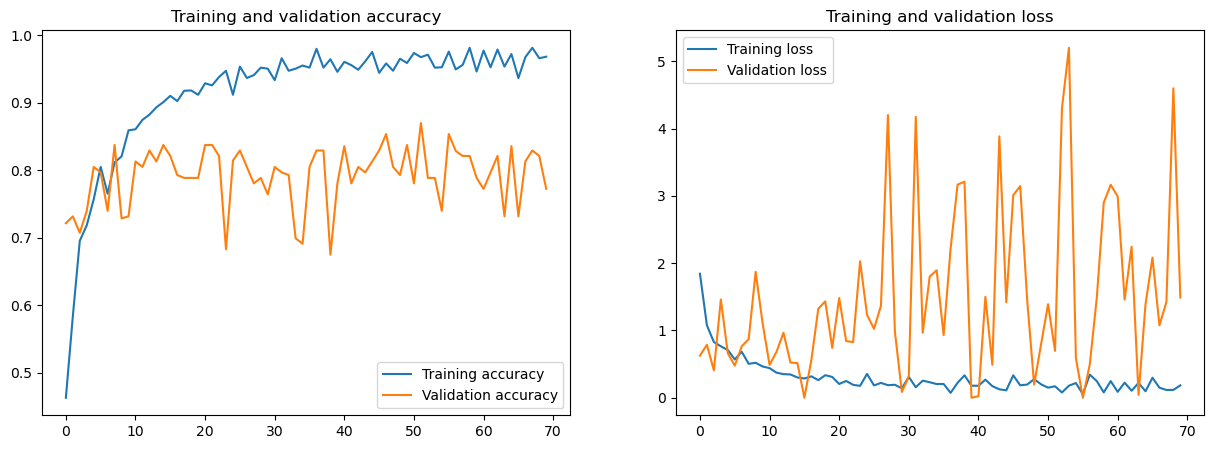

In [30]:
plot_accuracy_and_loss(history)

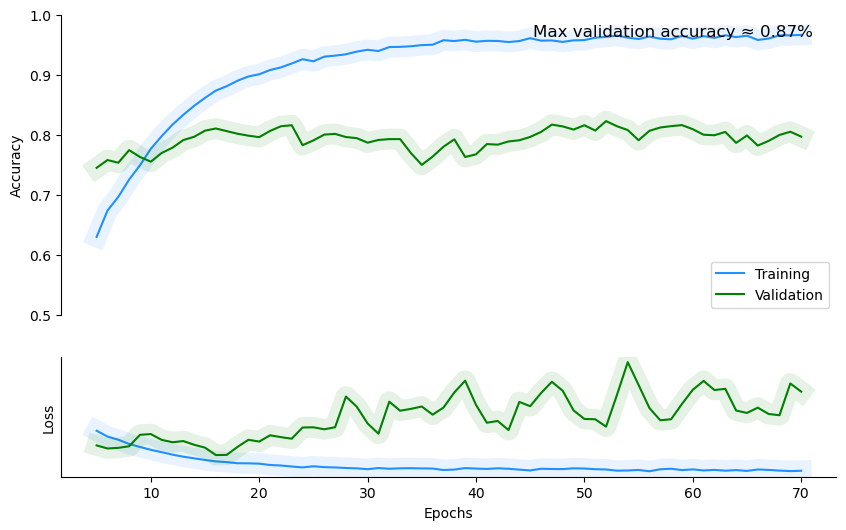

In [31]:
plot_history(history,xkcd=False)

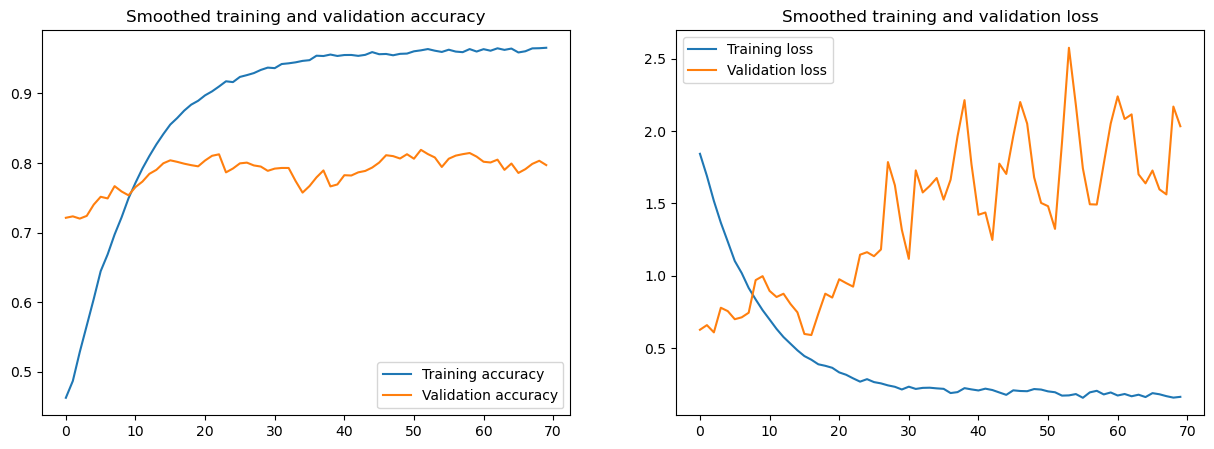

In [32]:
plot_smoothed_acc_and_loss(history, 0.8)

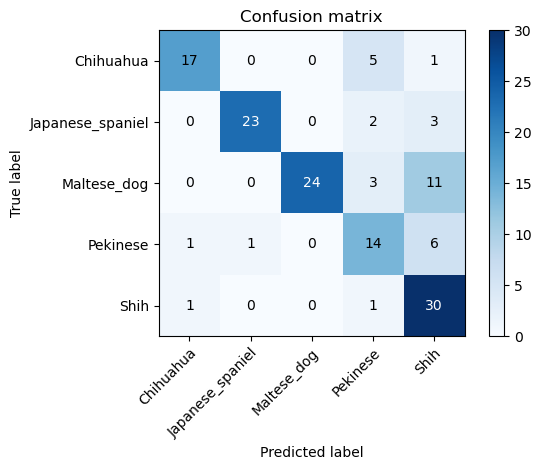

In [33]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [34]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_60_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

In [35]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  7072
Number of train classes:  60
Number of train samples per class: 118 

Number of validation samples:  1527
Number of validation classes:  60
Number of validation samples per class: 25 

Number of test samples:  1512
Number of test classes:  60
Number of test samples per class: 25 

Files for train subset for 60 classes 
 ['affenpinscher\\n02110627_10147.jpg', 'affenpinscher\\n02110627_10185.jpg', 'affenpinscher\\n02110627_10225.jpg', 'affenpinscher\\n02110627_10437.jpg', 'affenpinscher\\n02110627_10439.jpg', 'affenpinscher\\n02110627_10447.jpg', 'affenpinscher\\n02110627_10680.jpg', 'affenpinscher\\n02110627_10787.jpg', 'affenpinscher\\n02110627_10848.jpg', 'affenpinscher\\n02110627_10859.jpg', 'affenpinscher\\n02110627_10986.jpg', 'affenpinscher\\n02110627_11211.jpg', 'affenpinscher\\n02110627_11262.jpg', 'affenpinscher\\n02110627_11263.jpg', 'affenpinscher\\n02110627_11279.jpg', 'affenpinscher\\n02110627_11283.jpg', 'affenpinscher\\n02110627_11345.jpg', 

## Model

In [36]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_60_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                30780     
Total params: 27,591,036
Trainable params: 27,591,036
Non-trainable params: 0
_________________________________________________________________


In [38]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 143s - loss: 4.0934 - acc: 0.0248 - val_loss: 3.5436 - val_acc: 0.0789

Epoch 00001: val_loss improved from inf to 3.54359, saving model to tl_fine_tuning_60_breeds
Epoch 2/1000
 - 160s - loss: 3.6648 - acc: 0.0959 - val_loss: 2.7117 - val_acc: 0.2621

Epoch 00002: val_loss improved from 3.54359 to 2.71175, saving model to tl_fine_tuning_60_breeds
Epoch 3/1000
 - 145s - loss: 3.0836 - acc: 0.2079 - val_loss: 3.3741 - val_acc: 0.3404

Epoch 00003: val_loss did not improve from 2.71175
Epoch 4/1000
 - 141s - loss: 2.7924 - acc: 0.2619 - val_loss: 2.7905 - val_acc: 0.3968

Epoch 00004: val_loss did not improve from 2.71175
Epoch 5/1000
 - 141s - loss: 2.6217 - acc: 0.2930 - val_loss: 2.3669 - val_acc: 0.4313

Epoch 00005: val_loss improved from 2.71175 to 2.36692, saving model to tl_fine_tuning_60_breeds
Epoch 6/1000
 - 144s - loss: 2.4521 - acc: 0.3355 - val_loss: 1.6455 - val_acc: 0.4592

Epoch 00006: val_loss improved from 2.36692 to 1.64553, saving model to tl_fine_tun

## Results

In [40]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 33s 22ms/step


[1.7947002957579952, 0.5760582089424133]

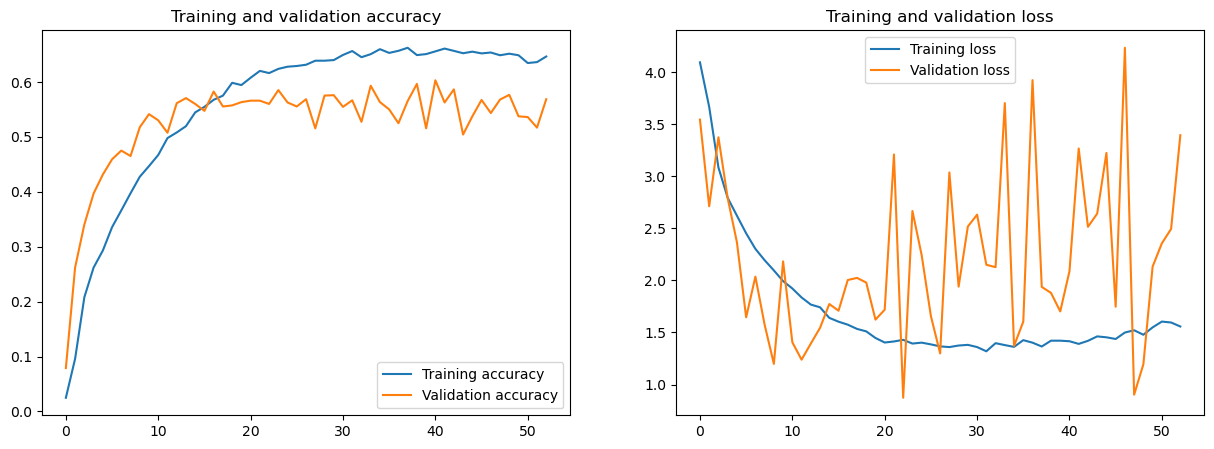

In [41]:
plot_accuracy_and_loss(history)

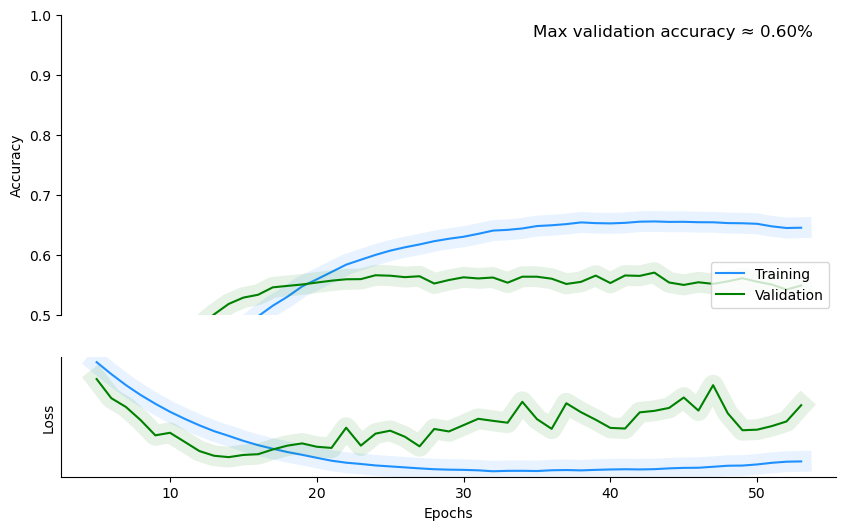

In [42]:
plot_history(history,xkcd=False)

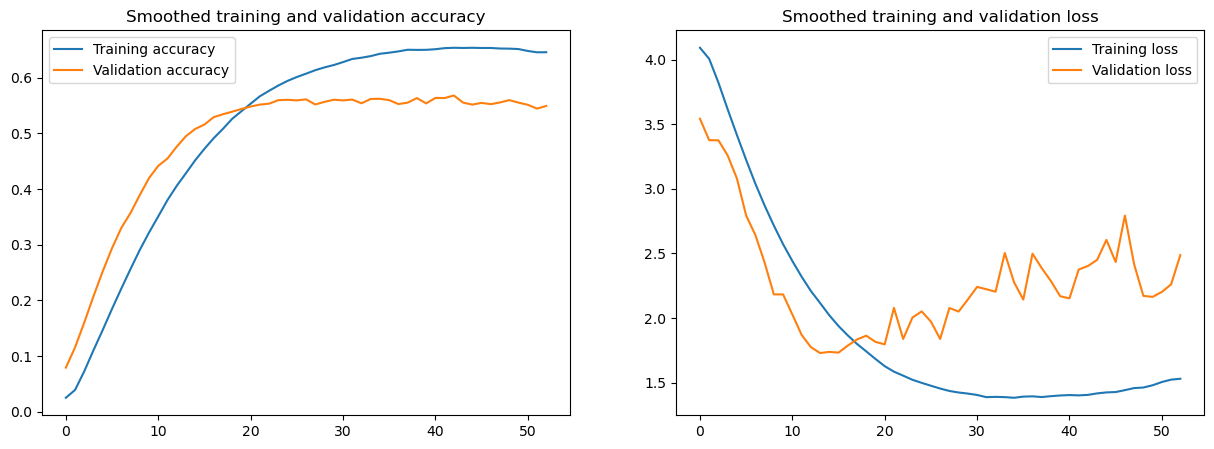

In [43]:
plot_smoothed_acc_and_loss(history, 0.8)

# 120 breeds

## Data preparation

In [44]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

# Load test images and labels
test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(STD_SIZE[0], STD_SIZE[1], 3), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels))
print(f"\nLoaded test images in test_features array: {test_features.shape}")

with open('classes_encoding_120_breeds', 'wb') as f:
    pickle.dump(classes_labels, f)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

In [45]:
print('Number of train samples: ',train_generator.samples)
print('Number of train classes: ',len(train_generator.class_indices))
print('Number of train samples per class:', round(train_generator.samples/len(train_generator.class_indices)),'\n')

print('Number of validation samples: ',validation_generator.samples)
print('Number of validation classes: ',len(validation_generator.class_indices))
print('Number of validation samples per class:', round(validation_generator.samples/len(validation_generator.class_indices)), '\n')

print('Number of test samples: ',test_generator.samples)
print('Number of test classes: ',len(test_generator.class_indices))
print('Number of test samples per class:', round(test_generator.samples/len(test_generator.class_indices)), '\n')

print('Files for train subset for',len(train_generator.class_indices),'classes \n', train_generator.filenames, '\n')
print('Files for validation subset for',len(validation_generator.class_indices),'classes \n', validation_generator.filenames,'\n')
print('Files for test subset for',len(test_generator.class_indices),'classes \n', test_generator.filenames,'\n')

Number of train samples:  14397
Number of train classes:  120
Number of train samples per class: 120 

Number of validation samples:  3099
Number of validation classes:  120
Number of validation samples per class: 26 

Number of test samples:  3084
Number of test classes:  120
Number of test samples per class: 26 

Files for train subset for 120 classes 
 ['Afghan_hound\\n02088094_1003.jpg', 'Afghan_hound\\n02088094_1007.jpg', 'Afghan_hound\\n02088094_1023.jpg', 'Afghan_hound\\n02088094_10263.jpg', 'Afghan_hound\\n02088094_10715.jpg', 'Afghan_hound\\n02088094_10822.jpg', 'Afghan_hound\\n02088094_10832.jpg', 'Afghan_hound\\n02088094_10982.jpg', 'Afghan_hound\\n02088094_11006.jpg', 'Afghan_hound\\n02088094_11172.jpg', 'Afghan_hound\\n02088094_11182.jpg', 'Afghan_hound\\n02088094_1126.jpg', 'Afghan_hound\\n02088094_1128.jpg', 'Afghan_hound\\n02088094_11432.jpg', 'Afghan_hound\\n02088094_1145.jpg', 'Afghan_hound\\n02088094_115.jpg', 'Afghan_hound\\n02088094_1150.jpg', 'Afghan_hound\\n02088

# Model

In [46]:
model = load_model(PATH + 'tl_freeze_conv_base_data_aug_120_breeds')

C:\ProgramData\Anaconda3\envs\virtEnv\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 27,621,816
Trainable params: 27,621,816
Non-trainable params: 0
_________________________________________________________________


In [48]:
set_trainable = False
for layer in model.layers[0].layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [49]:
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=1000, verbose=2,
    validation_data=validation_generator, validation_steps=validation_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_fine_tuning_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_fine_tuning_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/1000
 - 316s - loss: 4.9097 - acc: 0.0128 - val_loss: 4.6155 - val_acc: 0.0221

Epoch 00001: val_loss improved from inf to 4.61550, saving model to tl_fine_tuning_120_breeds
Epoch 2/1000
 - 302s - loss: 4.5891 - acc: 0.0314 - val_loss: 3.8444 - val_acc: 0.0805

Epoch 00002: val_loss improved from 4.61550 to 3.84438, saving model to tl_fine_tuning_120_breeds
Epoch 3/1000
 - 241s - loss: 4.1882 - acc: 0.0703 - val_loss: 3.5801 - val_acc: 0.1614

Epoch 00003: val_loss improved from 3.84438 to 3.58006, saving model to tl_fine_tuning_120_breeds
Epoch 4/1000
 - 257s - loss: 3.7767 - acc: 0.1148 - val_loss: 3.0065 - val_acc: 0.2186

Epoch 00004: val_loss improved from 3.58006 to 3.00648, saving model to tl_fine_tuning_120_breeds
Epoch 5/1000
 - 188s - loss: 3.4348 - acc: 0.1657 - val_loss: 2.9411 - val_acc: 0.2621

Epoch 00005: val_loss improved from 3.00648 to 2.94110, saving model to tl_fine_tuning_120_breeds
Epoch 6/1000
 - 165s - loss: 3.1652 - acc: 0.2069 - val_loss: 2.9676 - val

## Results

In [50]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 31s 10ms/step


[2.121939716326742, 0.44876784086227417]

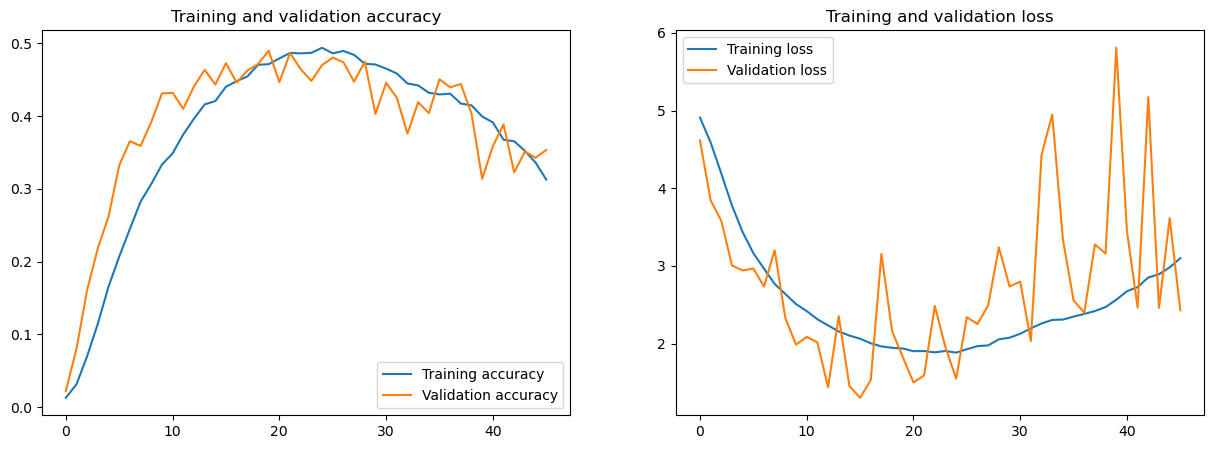

In [51]:
plot_accuracy_and_loss(history)

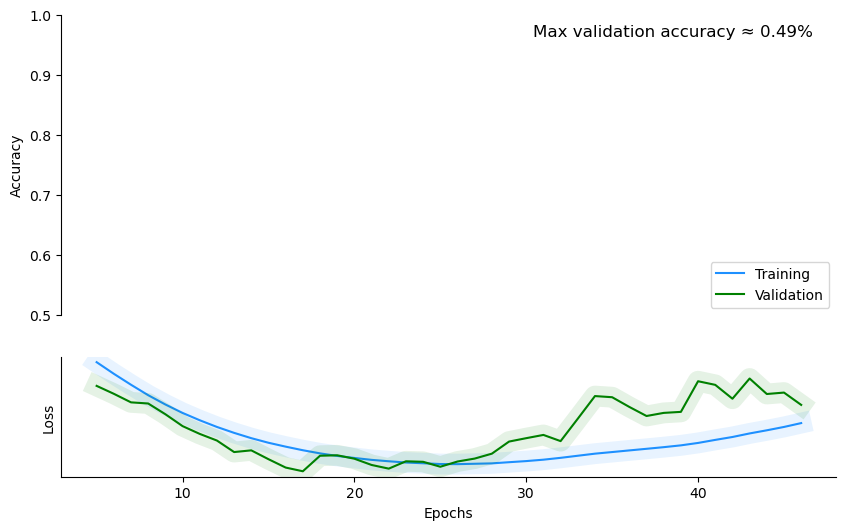

In [52]:
plot_history(history,xkcd=False)

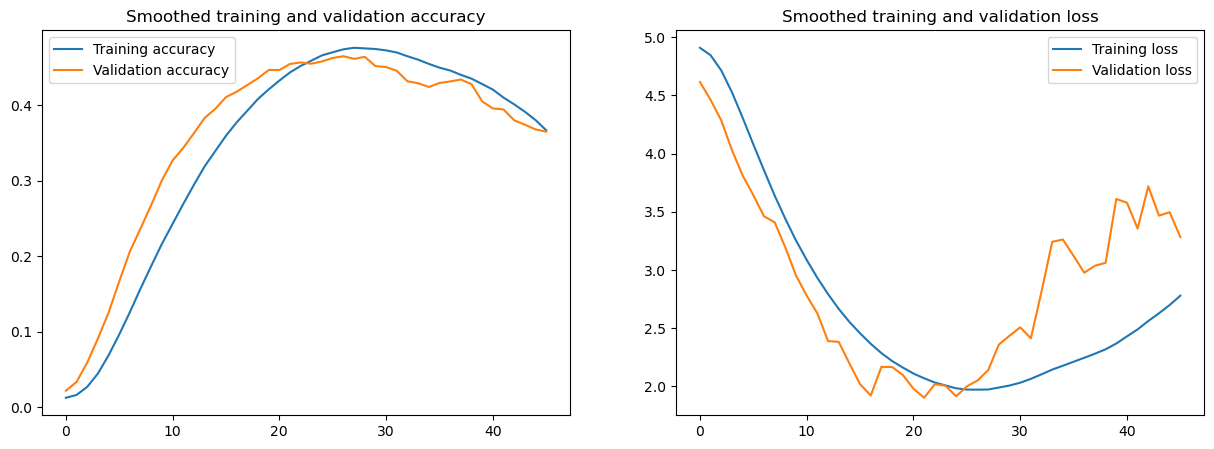

In [53]:
plot_smoothed_acc_and_loss(history, 0.8)